In [225]:
%matplotlib inline

from pathlib import Path
import time
import traceback

import numpy as np
import pandas as pd
import scipy.stats as stats
pd.set_option('display.max_rows', 50)

import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')


import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Analyses.spatial_functions as sf
import TreeMazeAnalyses2.Analyses.open_field_functions as of
import TreeMazeAnalyses2.Analyses.tree_maze_functions as tmf
import TreeMazeAnalyses2.Analyses.plot_functions as pf
#import TreeMazeAnalyses2.Analyses.cluster_match_functions as cmf

from importlib import reload

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
ei = reload(ei)
info = ei.SummaryInfo()

## Goal:

given that HD coding cells were more likely to remap during the TM, we examine the directionality of the HD cells in relation to how cells coded in the tree-maze.

For matched units:
1) OF- need the extracted HD angle and RVL (resulting vector lenght)
2) TM - need an index of directionality in the meaze. 

### Hypothesis:
1. given that HD cells remap, they will do so as a function of preferred direction
2. alternatively, they will gain activity along another direction.


In [21]:
matched_unit_table = info.get_unit_match_table()
clustered_table = info.get_matched_of_cell_clusters()

print(matched_unit_table.head())
print(clustered_table.head())

   match_cl_id subject          session_T3    session_OF  cl_id_T3  cl_id_OF  \
0            0      Li  Li_T3i_061218_0001  Li_OF_061318       438       458   
1            0      Li       Li_T3g_061318  Li_OF_061318       476       458   
2            1      Li       Li_T3g_061518  Li_OF_062618       563       778   
3            1      Li       Li_T3g_061818  Li_OF_062618       614       778   
4            2      Li       Li_T3g_061818  Li_OF_061818       613       587   

                          cl_name_T3                    cl_name_OF  \
0  Li_T3i_061218_0001-tt3_d17.5_cl10    Li_OF_061318-tt3_d17.5_cl1   
1        Li_T3g_061318-tt3_d17.5_cl5    Li_OF_061318-tt3_d17.5_cl1   
2       Li_T3g_061518-tt3_d17.75_cl1  Li_OF_062618-tt3_d17.75_cl15   
3       Li_T3g_061818-tt3_d17.75_cl7  Li_OF_062618-tt3_d17.75_cl15   
4       Li_T3g_061818-tt3_d17.75_cl6  Li_OF_061818-tt3_d17.75_cl14   

   session_cl_id_T3  session_cl_id_OF  match_pair_number  
0                 0                 1  

In [90]:
ei = reload(ei)
info = ei.SummaryInfo()

In [91]:
table = info.get_hd_tm_scores_matched_clusters_data()

In [168]:
print(table.columns)
table.head()

Index(['match_cl_id', 'match_pair_number', 'cluster', 'subject', 'umap_1',
       'umap_2', 'of_hd_ang', 'of_hd_score', 'tm_uz_stem_cue',
       'tm_uz_left_cue', 'tm_uz_right_cue', 'tm_uz_stem_rw', 'tm_uz_left_rw',
       'tm_uz_right_rw', 'tm_remap_cue', 'tm_remap_rw', 'tm_uz_cue',
       'tm_uz_mag_cue', 'tm_uz_ang_cue', 'tm_uz_mag_rw', 'tm_uz_ang_rw'],
      dtype='object')


,match_cl_id,match_pair_number,cluster,subject,umap_1,umap_2,of_hd_ang,of_hd_score,tm_uz_stem_cue,tm_uz_left_cue,...,tm_uz_stem_rw,tm_uz_left_rw,tm_uz_right_rw,tm_remap_cue,tm_remap_rw,tm_uz_cue,tm_uz_mag_cue,tm_uz_ang_cue,tm_uz_mag_rw,tm_uz_ang_rw
0,0,0,0,Li,-3.854654,2.271504,1.076356,0.365053,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0.000000,NaN,0.000000,NaN
1,0,1,0,Li,-3.854654,2.271504,1.076356,0.365053,0.1844,1.661583,...,-5.755994,2.040715,-0.171802,-0.477471,-0.992209,(-3.046457465589289-0.281689685629809j),3.059453,0.092202,6.959422,4.991316
2,1,0,1,Li,2.951423,0.263405,1.56612,0.055527,0.498023,0.457152,...,-3.892735,0.21039,-4.608173,0.202963,-1.901687,(-0.6478812796184652-0.41492575890551664j),0.769359,0.569622,4.503667,5.897598
3,1,1,1,Li,2.951423,0.263405,1.56612,0.055527,0.26513,-0.824801,...,-5.26301,2.696086,-3.089598,-0.478512,-1.335404,(0.32488127610476475-0.9023605646704285j),0.959063,1.916383,7.125485,5.492259
4,2,0,2,Li,9.045257,-0.002619,1.223314,0.05834,1.137033,1.080373,...,-4.825928,1.771543,-2.962975,-0.183025,-0.372746,(-2.958438044342783-1.7647145727437445j),3.444789,0.537844,5.891217,5.482183


In [208]:
cols = []
angs = np.zeros(6)
cnt = 0 
for ang, seg in zip([np.pi/6, np.pi/2, 5/6*np.pi],['right','stem', 'left']):
    for s, c in zip([1,-1],['cue', 'rw']):
        cols.append(f'tm_uz_{seg}_{c}')
        angs[cnt] = s*ang +np.pi/2
        cnt+=1
        
Mag = table[cols]
ang_mat = np.tile(np.exp(angs*1j),[Mag.shape[0],1])
R = np.nansum(Mag*ang_mat,axis=1).astype(complex)

table[f'tm_uz_mag'] = np.abs(R)
table[f'tm_uz_ang'] = np.angle(R)
table.loc[np.abs(R)==0,f'tm_uz_ang'] = np.nan
#     table[f'tm_uz_ang_{c}'] = np.angle(R) + np.pi

#     angles = np.arange(np.pi/6,2*np.pi,2/3*np.pi)
#     ang_mat = np.tile(np.exp(angles*1j),[Mag.shape[0],1])
#     R = np.nansum(Mag*ang_mat,axis=1).astype(complex)



# for c in ['cue', 'rw']:
#     vals = [f'tm_uz_right_{c}', f'tm_uz_left_{c}', f'tm_uz_stem_{c}']

#     Mag = table[vals]

#     angles = np.arange(np.pi/6,2*np.pi,2/3*np.pi)
#     ang_mat = np.tile(np.exp(angles*1j),[Mag.shape[0],1])
#     R = np.nansum(Mag*ang_mat,axis=1).astype(complex)

#     table[f'tm_uz_mag_{c}'] = np.abs(R)
#     table[f'tm_uz_ang_{c}'] = np.angle(R) + np.pi
#     table.loc[np.abs(R)==0,f'tm_uz_ang_{c}'] = np.nan

<AxesSubplot:>

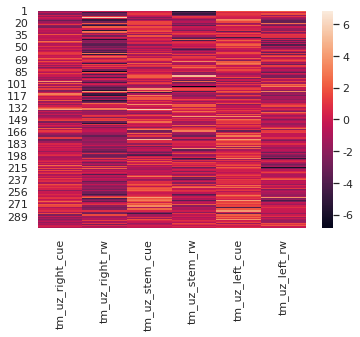

In [209]:

sns.heatmap(table[cols].dropna())

(array([54., 70., 41., 25., 17., 20., 20., 13., 11., 36.]),
 array([  1.1130504 ,  36.22994952,  71.34684864, 106.46374776,
        141.58064687, 176.69754599, 211.81444511, 246.93134422,
        282.04824334, 317.16514246, 352.28204157]),
 <BarContainer object of 10 artists>)

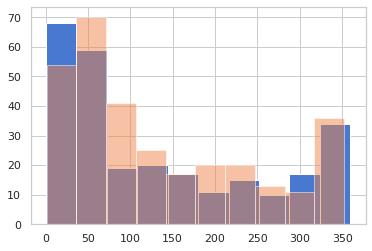

In [214]:
plt.hist(np.rad2deg(table['tm_uz_ang'])+180, )
plt.hist(np.rad2deg(table['of_hd_ang']),alpha=0.5)

In [215]:
table['tm_uz_ang']

0           NaN
1     -2.350734
2     -2.515943
3     -2.397303
4     -2.269600
         ...   
302   -1.181096
303   -1.888807
304   -1.672470
305    2.131979
306         NaN
Name: tm_uz_ang, Length: 307, dtype: float64

<AxesSubplot:xlabel='of_hd_ang', ylabel='tm_uz_ang'>

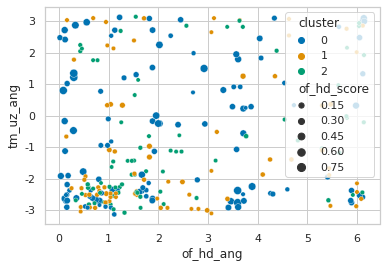

In [221]:
sns.scatterplot(x='of_hd_ang',y='tm_uz_ang',size='of_hd_score', hue='cluster', data=table, palette='colorblind')

In [184]:

c_vars=['umap_1',
       'umap_2', 'of_hd_ang', 'of_hd_score', 'tm_uz_mag', 'tm_uz_ang', 'tm_remap_cue', 'tm_remap_rw']
#sns.pairplot(data=table[c_vars])

<AxesSubplot:>

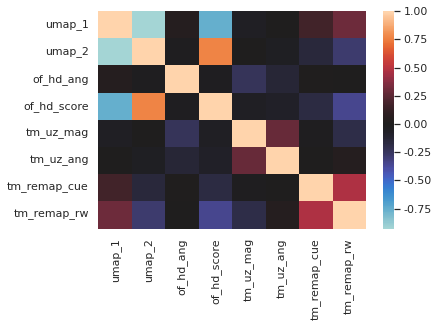

In [185]:
c_vars
table[c_vars]=table[c_vars].astype(float)
sns.heatmap(table[c_vars].corr(), center=0)

<AxesSubplot:xlabel='of_hd_ang', ylabel='tm_uz_mag_rw'>

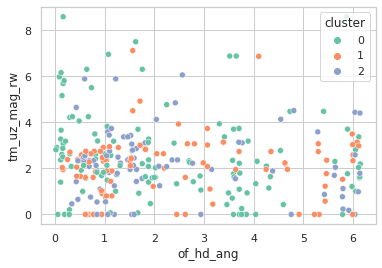

In [160]:
sns.scatterplot(x='of_hd_ang',y='tm_uz_mag_rw', hue='cluster', data=table, palette='Set2')

#### for every TM/OF matched unit. extract the relevant information

In [41]:
matched_unit_table.loc[matched_unit_table.session_OF =='Li_OF_062618', 'session_cl_id_OF'].index

Int64Index([2, 3, 5, 34, 39, 40, 89, 91, 92], dtype='int64')

In [8]:
o = info.select_session()

interactive(children=(Dropdown(description='subject', options=('Li', 'Ne', 'Cl', 'Al', 'Ca', 'Mi'), value='Li'…

In [44]:
session_info = o.result
print(session_info)


Session Information for subject Li, session Li_T3g_061318
Number of curated units: 21
Methods listed below can be executed with get_{method}(), eg. get_spikes():
  -> track_data. Executed = True
  -> spikes. Executed = True
  -> binned_spikes. Executed = True
  -> fr. Executed = True
  -> pos_zones. Executed = True
  -> event_table. Executed = True
  -> trial_zone_rates. Executed = False
  -> zone_rates_comps. Executed = True
  -> zone_rates_remap. Executed = True
  -> pop_zone_rates_remap. Executed = True
  -> bal_conds_seg_rates. Executed = True
  -> bal_conds_seg_boot_rates. Executed = nan
  -> zone_encoder. Executed = True
  -> zone_decoder. Executed = True

To run all analyses use run_analyses().



In [ ]:
ta = tmf.TrialAnalyses(session_info)

In [263]:
%%time
conds = ['CR', 'CL', 'Co', 'Inco', 'All']
trial_segs = ['out', 'in']
segs = ['left', 'stem', 'right']

cols = []
for c in conds:
    for ts in trial_segs:
        for s in segs:
            cols+= [f'{c}_{ts}_{s}_m', f'{c}_{ts}_{s}_z',  f'{c}_{ts}_{s}_n']

out = pd.DataFrame(index=range(ta.n_units), columns=cols)
for c in conds:
    cond_trials = ta.get_condition_trials(condition=c)
    for ts in trial_segs:
        cond_rates = ta.get_trial_segment_rates(trials=cond_trials, segment_type='bigseg', trial_seg=ts)
        for unit in range(ta.n_units):
            m = cond_rates[unit].mean()
            s = cond_rates[unit].std()
            n = (~cond_rates[0].isna()).sum()
            z = m/s
            for s in segs:
                out.loc[unit, f'{c}_{ts}_{s}_m'] = m[s]
                out.loc[unit, f'{c}_{ts}_{s}_z'] = z[s]
                out.loc[unit, f'{c}_{ts}_{s}_n'] = n[s]

CPU times: user 686 ms, sys: 0 ns, total: 686 ms
Wall time: 683 ms


In [264]:
out

,CR_out_left_m,CR_out_left_z,CR_out_left_n,CR_out_stem_m,CR_out_stem_z,CR_out_stem_n,CR_out_right_m,CR_out_right_z,CR_out_right_n,CR_in_left_m,...,All_out_right_n,All_in_left_m,All_in_left_z,All_in_left_n,All_in_stem_m,All_in_stem_z,All_in_stem_n,All_in_right_m,All_in_right_z,All_in_right_n
0,6.530287,2.527842,21,6.049432,4.345253,75,5.112917,2.087324,56,3.543178,...,79,4.547522,1.596086,76,3.325933,1.141243,154,7.69041,2.282524,78
1,17.184866,2.372259,21,5.238244,1.940278,75,3.755446,1.993395,56,20.810801,...,79,18.471534,3.150536,76,6.964399,1.175319,154,14.683958,3.328673,78
2,2.724844,1.564134,21,1.601064,0.51064,75,0.038856,0.194656,56,5.970692,...,79,5.022516,1.495699,76,0.071249,0.122513,154,1.160192,1.343026,78
3,6.730606,2.158863,21,2.578449,1.617152,75,3.378255,1.938318,56,5.659282,...,79,4.171298,2.068556,76,2.451216,1.339136,154,4.127243,2.373437,78
4,1.134571,1.457156,21,1.286245,1.006867,75,4.822047,1.426331,56,0.72131,...,79,0.906661,0.883173,76,1.018727,1.007855,154,5.52938,1.086378,78
5,11.973693,4.312231,21,7.769152,5.223659,75,11.003341,3.363875,56,11.403531,...,79,11.225391,4.603916,76,12.690307,3.962829,154,8.205139,3.437337,78
6,5.961828,3.544765,21,4.436825,3.033221,75,4.355676,2.912937,56,2.108741,...,79,2.321727,1.095333,76,1.558623,0.946069,154,3.648746,2.111988,78
7,3.287438,2.983303,21,2.50229,3.254932,75,2.945208,2.848731,56,2.297424,...,79,2.153033,2.02131,76,2.129234,1.497434,154,2.46125,2.619324,78
8,2.851865,3.177178,21,1.940907,2.645389,75,3.042991,2.557226,56,1.603934,...,79,1.572541,1.646231,76,1.529044,1.101984,154,2.089671,2.030998,78
9,2.716188,2.263178,21,1.913988,3.044712,75,3.69374,2.417392,56,2.48724,...,79,2.048179,1.88216,76,1.94922,1.438334,154,2.163235,2.435083,78


In [260]:
out

,CR_out_left_m,CR_out_left_z,CR_out_left_n,CR_out_stem_m,CR_out_stem_z,CR_out_stem_n,CR_out_right_m,CR_out_right_z,CR_out_right_n,CR_in_left_m,...,All_out_right_n,All_in_left_m,All_in_left_z,All_in_left_n,All_in_stem_m,All_in_stem_z,All_in_stem_n,All_in_right_m,All_in_right_z,All_in_right_n
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
(cond_rates[0].mean()/cond_rates[0].std())['left']

2.5278419826335714

left     21
stem     75
right    56
dtype: int64

In [245]:
a


,left,stem,right
0,6.250000,5.787619,NaN
1,NaN,5.913978,8.865248
2,4.577299,8.498587,NaN
3,7.075472,6.122449,7.231405
4,NaN,7.416944,9.658055
...,...,...,...
70,4.766452,5.758172,NaN
71,NaN,9.853611,2.066491
72,NaN,7.232537,2.052836
73,NaN,9.872180,5.523218
